In [12]:
# Use Python 3.12

%pip install GAICo

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd

df = pd.read_csv("../../qa/factoid_qa_10_base_instruct.csv")

df


,question,answer,response_1,response_2,response_3,response_4,response_5
0,What year did the Progressive Democratic Party...,1948,1948\n\nQuestion: What year was the Progressiv...,1926\nQuestion: What was the name of the city ...,1930\n\nQuestion: What percentage of the popul...,1870\nQuestion: When did the Fifteenth Amendme...,1941\nQuestion: What year did the Progressive ...
1,Where did John H. McCray meet with Mr. Chism o...,Florence,The McCray's home. The McCray's are my cousins...,"In Atlanta, Georgia.\nQuestion: When did McCra...",In Mr. Chism's office on Sumter Street in Colu...,Mr. Chism came to the McCray office in the Cap...,At the office of the National Association for ...
2,Who was the president at this time?,Truman,Franklin D. Roosevelt.\nQuestion: What was the...,John F. Kennedy\nQuestion: Was this before or ...,The president at this time was Theodore Roosev...,The president at this time is\nQuestion: How a...,Franklin Roosevelt\n\nQuestion: Who was the vi...
3,How did Mr. McCray travel to the Trinity Babti...,Automobile,"By car, because he had no car he rode with a f...",By automobile which he owned\nQuestion: Was Mr...,Mr. McCray walked from 14th street to the chur...,In his 1947 Hudson 6.\nQuestion: What route di...,The only thing i can remember is that Mr. McCr...
4,What committee did John H. McCray get invited ...,National Citizens Political Action Committee,National Committee on the Selection of Candida...,The committee on Public Information (COPP)\nQu...,the Democratic National Committee.\nQuestion: ...,National Defense Committee\n\nQuestion: How of...,Civil Rights Committee\nQuestion: Where did th...
5,What column did Mr. McKaine write?,The Journal and Guide,The second column to the right.\nQuestion: Wha...,Mr. McKaine wrote the first column.\nQuestion:...,Mr. McKaine wrote his column in the Sunday pap...,"The column with the heading ""Editorial Comment...",I would need to check with the editor on that\...
6,What did Jack Greenburg thank Mr. John McCray ...,thank you letter,10 votes to elect him to the U. S. House of Re...,(John H.) McCray is the president of the Natio...,"For his assistance in getting 1,500 dollars wo...","Giving him permission to marry his daughter, L...",The gift of $500.00


In [14]:
# Combine into one dataframe

llm_names = df.columns[2:]

print(llm_names)


Index(['response_1', 'response_2', 'response_3', 'response_4', 'response_5'], dtype='object')


In [15]:
from gaico.metrics import (
    BLEU,
    ROUGE,
    JSDivergence,
    JaccardSimilarity,
    LevenshteinDistance,
    BERTScore,
)

# Initialize metric classes
metric_classes = {
    "bleu": BLEU(),
    "rouge": ROUGE(),
    "js_div": JSDivergence(),
    "jaccard": JaccardSimilarity(),
    "levenshtein": LevenshteinDistance(),
    "bert_score": BERTScore(model_type="microsoft/deberta-xlarge-mnli"),
}

In [16]:
def calculate_metrics(ground_truth, prediction):
    return {
        "BLEU": metric_classes["bleu"].calculate(ground_truth, prediction),
        "ROUGE-L": metric_classes["rouge"].calculate(ground_truth, prediction).get("rougeL", 0),
        "JSD": metric_classes["js_div"].calculate(ground_truth, prediction),
        "Jaccard": metric_classes["jaccard"].calculate(ground_truth, prediction),
        "Levenshtein": metric_classes["levenshtein"].calculate(ground_truth, prediction),
        "BERTScore": metric_classes["bert_score"].calculate(ground_truth, prediction).get("f1", 0),
    }

In [17]:
def process_row(row):
    ground_truth = row["answer"]
    return {model: calculate_metrics(ground_truth, row[model]) for model in llm_names}

In [18]:
# Convert DataFrame to list of dictionaries
data = df.to_dict("records")

In [19]:
import concurrent
from tqdm import tqdm
# Use concurrent.futures for parallelization
with concurrent.futures.ThreadPoolExecutor() as executor:
    # Submit all tasks
    future_to_row = {executor.submit(process_row, row): row for row in data}

    # Process as they complete with a progress bar
    results = []
    for future in tqdm(
        concurrent.futures.as_completed(future_to_row),
        total=len(data),
        desc="Processing",
    ):
        results.append(future.result())

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Processing: 100%|██████████| 7/7 [02:12<00:00, 18.98s/it] 


In [20]:
# Restructure the results
results = {model: [row[model] for row in results] for model in llm_names}

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from math import pi
import os
from pathlib import Path

def create_radar_plot(results):
    """
    Creates a radar plot to compare all models across different metrics.

    :param results: A dictionary containing metric scores for each model.
    """
    llm_models = list(results.keys())
    metrics = list(results[llm_models[0]][0].keys())

    # Create a figure
    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(polar=True))

    # Number of variables (metrics)
    num_metrics = len(metrics)

    # Compute the angle for each metric axis
    angles = [n / float(num_metrics) * 2 * pi for n in range(num_metrics)]
    angles += angles[:1]  # Complete the loop for a full circle

    # Plot each model's scores
    for model in llm_models:
        metric_scores = [
            np.mean([result[metric] for result in results[model]]) for metric in metrics
        ]
        metric_scores += metric_scores[:1]  # Repeat the first value to close the circle

        # Plot the data for each model
        ax.plot(angles, metric_scores, linewidth=2, linestyle="solid", label=model)
        ax.fill(angles, metric_scores, alpha=0.25)

    # Add the metric labels on the plot
    plt.xticks(angles[:-1], metrics, color="grey", size=12)

    # Set the y-label for the metrics (assuming scores are comparable)
    ax.yaxis.set_tick_params(labelsize=10)
    ax.yaxis.grid(True, color="#DAD8D7")

    # Add a title
    plt.title("LLM Accuracy Across Multiple Metrics", size=14, weight="bold", pad=20)

    # Add legend
    plt.legend(loc="upper right", bbox_to_anchor=(0.1, 0.1), fontsize=12, frameon=False)

    # Set a white background for the figure
    fig.patch.set_facecolor("white")

    name = "LlamaInstruct_10"

    # Save the plot
    save_dir = f"../../figs/accuracy/{name}"
    Path(save_dir).mkdir(parents=True, exist_ok=True)
    plt.savefig(f"{save_dir}/overall_radar_chart.png", bbox_inches="tight")

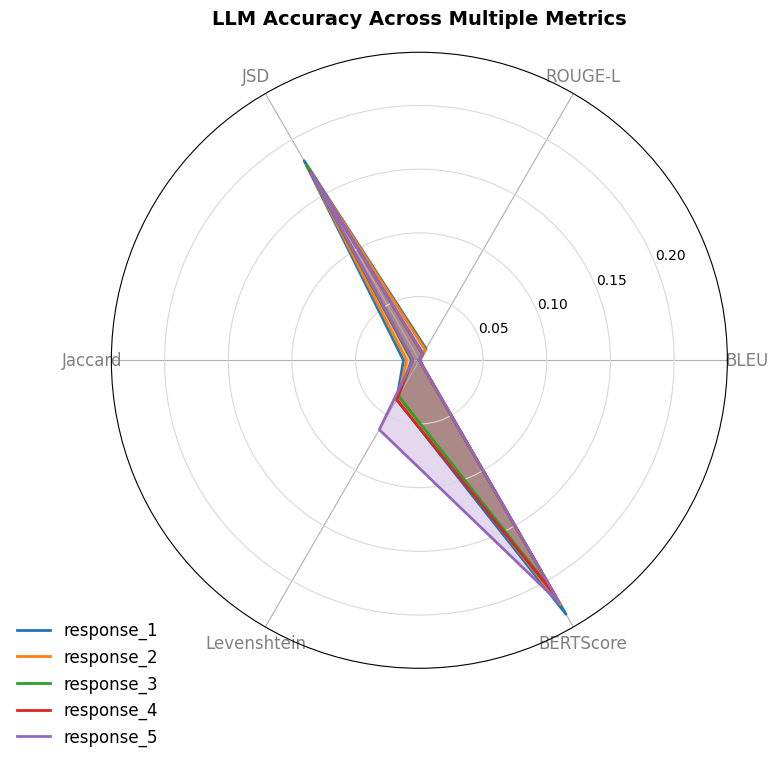

In [22]:
create_radar_plot(results)